In [1]:
from emocon.datasets import load_video_dataloaders, investigate_video, display_gif

In [2]:
train, test, dev =load_video_dataloaders()
i, item = next(enumerate(train))


In [3]:
investigate_video(item)

video torch.Size([3, 16, 224, 224])
video_name dia622_utt6.mp4
video_index 6178
clip_index 0
aug_index 0
label 4
Video label: anger


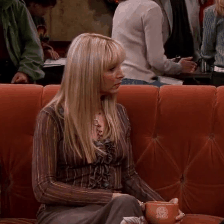

In [4]:
display_gif(item['video'])

In [5]:
from transformers import VideoMAEForVideoClassification
from emocon.constants import EMOTION2LABEL, LABEL2EMOTION
import torch

model_name = "./videomae-base-finetuned-meld/checkpoint-4069/"
model = VideoMAEForVideoClassification.from_pretrained(
            model_name,
            label2id=EMOTION2LABEL,
            id2label=LABEL2EMOTION,
            ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
        )

In [18]:
def collate_fn(examples):
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

inputs = collate_fn([item])
inputs['pixel_values'].to('cuda')
inputs['labels'].to(model.device)

tensor([4], device='cuda:0')

In [22]:
model.device, inputs['pixel_values'].device, inputs['labels'].device

(device(type='cuda', index=0), device(type='cpu'), device(type='cpu'))

In [42]:
out = model.videomae.cpu()(inputs['pixel_values'])
out.last_hidden_state[:, 0, :].squeeze().shape

torch.Size([768])

In [38]:
model.classifier.in_features

768

In [26]:
import torch.nn as nn
from collections import namedtuple
import torch.functional as F


class VMAESimCLR(nn.Module):
    
    def __init__(self, model_name, out_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)
        model = VideoMAEForVideoClassification.from_pretrained(
            model_name,
            label2id=EMOTION2LABEL,
            id2label=LABEL2EMOTION,
            ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
        )
        self.features = model.videomae
        
        num_features = model.classifier.in_features
        # projection MLP
        self.l1 = nn.Linear(num_features, num_features)
        self.l2 = nn.Linear(num_features, out_dim)
        
        # TODO: Decide to remove or keep it
        self.criterion = nn.CrossEntropyLoss()
        self.output = namedtuple("output", ["loss","embeds", "logits"])
        
    def forward(self, **kwargs):
        labels = kwargs['labels']
        video = kwargs["pixel_values"]
        
        # video = video.to(self.mae.device)
        embeds = self.features(pixel_values=video).last_hidden_state[:, 0, :]
        embeds = embeds.squeeze()
        
        logits = self.l1(embeds)
        logits = F.relu(logits)
        logits = self.l2(logits)
        
        loss = self.get_loss(logits, labels)
        
        return  (loss, embeds, logits)
    
    def get_loss(self, logits, labels):
        if not isinstance(labels, torch.Tensor):
            labels = torch.tensor(labels)
        loss = self.criterion(logits, labels)
        return loss

tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True,  True,  True,  True],
        [ True,  True,  True,  True, False,  True,  True,  True],
        [ True,  True,  True,  True,  True, False,  True,  True],
        [ True,  True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True,  True,  True, False]])

In [ ]:
import numpy as np

class NTXentLoss(torch.nn.Module):

    def __init__(self, device, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

In [7]:
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error as mse
from transformers import TrainingArguments, Trainer



class ContrastiveTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.loss_function = torch.nn.KLDivLoss(reduction="batchmean")
        self.loss_function_logits = torch.nn.CrossEntropyLoss()
        
        self.labels = None
     

    def compute_loss(self, model, inputs, return_outputs=False):
        self.labels = inputs['labels']         
        
        output = model(**inputs)
        
        loss = output.loss
        logits = output.logits
        # Compute the true label loss
        student_target_loss = studnet_loss

        # Calculate final loss
        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        
        return (loss, logits) if return_outputs else loss

In [8]:

model_name = "distilled-vmae"
num_epochs = 11
batch_size = 4

args = TrainingArguments(
    model_name,
    label_names='labels',
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_score",
    max_steps= (train.num_videos // batch_size) * num_epochs,
    save_total_limit =3,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=dev,
    data_collator=collate_fn,
    compute_metrics= lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions[0].argmax(-1)),
        "f1_score": f1_score(pred.label_ids, pred.predictions[0].argmax(-1), average='weighted')
    },
)

/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
trainer.train()

/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 